# ExoNAMD API v1.0


## Summary

The observer wants to compute the relative and/or absolute NAMD of:

- a given multiplanetary system;
- a subset of multiplanetary systems;
- all the known ones.

This tool handles all of the above cases.


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import pandas as pd
import swifter
import warnings
from loguru import logger

from exonamd.catalog import download_nasa_confirmed_planets
from exonamd.utils import ROOT
from exonamd.utils import fetch_aliases
from exonamd.utils import update_host
from exonamd.utils import update_planet
from exonamd.utils import check_name
from exonamd.solve import solve_values
from exonamd.interp import interp_eccentricity
from exonamd.interp import interp_mass
from exonamd.interp import interp_inclination
from exonamd.interp import interp_sma
from exonamd.solve import solve_relincl
from exonamd.interp import interp_trueobliq
from exonamd.utils import groupby_apply_merge
from exonamd.solve import solve_namd
from exonamd.solve import solve_namd_mc
from exonamd.plot import simple_plot
from exonamd.plot import pop_plot


warnings.filterwarnings("ignore", category=RuntimeWarning, module="pandas")
pd.options.display.max_columns = 20
pd.options.display.max_rows = 30
pd.options.mode.copy_on_write = True
swifter.set_defaults(
    npartitions=None,
    dask_threshold=1,
    scheduler="processes",
    progress_bar=True,
    progress_bar_desc=None,
    allow_dask_on_strings=False,
    force_parallel=False,
)

### Task 1: getting the data

This task retrieves the parameters of confirmed systems from the NASA Exoplanet Archive database.


In [3]:
df, df_old = download_nasa_confirmed_planets(
    sy_pnum=6,
    from_scratch=True,
)

2024-08-18 22:41:38.677 | INFO     | exonamd.catalog:download_nasa_confirmed_planets:17 - Downloading NASA Exoplanet Archive confirmed planets
2024-08-18 22:41:38.678 | DEBUG    | exonamd.catalog:download_nasa_confirmed_planets:28 - Defining the SQL query to retrieve the required data
2024-08-18 22:41:38.679 | DEBUG    | exonamd.catalog:download_nasa_confirmed_planets:65 - Making the request to the API


2024-08-18 22:41:54.934 | INFO     | exonamd.catalog:download_nasa_confirmed_planets:81 - Data fetched


### Task 2: dealing with the aliases


Fetch aliases


In [4]:
aliases = fetch_aliases(df["hostname"].unique())

2024-08-18 22:41:54.969 | INFO     | exonamd.utils:fetch_aliases:309 - Fetching aliases for host stars
2024-08-18 22:42:00.367 | INFO     | exonamd.utils:fetch_nea_aliases:158 - Fetched 2/2 entries on try 1


Curate aliases


In [5]:
logger.info("Updating host and planet names")
df["hostname"] = df.swifter.apply(update_host, args=(aliases,), axis=1)
df["pl_name"] = df.swifter.apply(update_planet, args=(aliases,), axis=1)
logger.info("Names updated")

2024-08-18 22:42:00.425 | INFO     | __main__:<module>:1 - Updating host and planet names


Pandas Apply:   0%|          | 0/107 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/107 [00:00<?, ?it/s]

2024-08-18 22:42:00.453 | DEBUG    | exonamd.utils:update_planet:425 - Updating planet Kepler-90 i to KOI-351 i
2024-08-18 22:42:00.453 | DEBUG    | exonamd.utils:update_planet:425 - Updating planet Kepler-90 i to KOI-351 i
2024-08-18 22:42:00.454 | INFO     | __main__:<module>:4 - Names updated


Check consistency of planet names


In [6]:
logger.info("Checking consistency of planet names")
name_ok = df.groupby("hostname")["pl_name"].apply(check_name)

for hostname in name_ok[~name_ok].index:
    logger.error(f"Inconsistent planet names for {hostname}")
logger.info("Consistency check done")

2024-08-18 22:42:00.487 | INFO     | __main__:<module>:1 - Checking consistency of planet names
2024-08-18 22:42:00.490 | INFO     | __main__:<module>:6 - Consistency check done


### Task 3: computing missing values (if any) from simple equations


In [7]:
logger.info("Computing missing values from simple relations")
df[
    [
        "pl_orbsmax",
        "pl_ratdor",
        "st_rad",
        "pl_rade",
        "pl_ratror",
        "pl_orbper",
        "st_mass",
    ]
] = df.swifter.apply(solve_values, axis=1)
logger.info("Missing values computed")

2024-08-18 22:42:00.527 | INFO     | __main__:<module>:1 - Computing missing values from simple relations


Pandas Apply:   0%|          | 0/107 [00:00<?, ?it/s]

2024-08-18 22:42:00.574 | INFO     | __main__:<module>:13 - Missing values computed


Drop columns that are no longer needed


In [8]:
logger.debug("Dropping columns that are no longer needed")
df.drop(
    columns=[
        "pl_ratdor",
        "st_rad",
        "pl_ratror",
        "pl_orbper",
        "st_mass",
    ],
    inplace=True,
)
logger.debug("Columns dropped")

2024-08-18 22:42:00.601 | INFO     | __main__:<module>:1 - Dropping columns that are no longer needed
2024-08-18 22:42:00.602 | INFO     | __main__:<module>:12 - Columns dropped


### Task 4: storing the curated database


In [9]:
logger.info("Storing the curated database")
if df_old is not None:
    df = pd.concat([df.copy(), df_old], ignore_index=True)
    df = df.drop_duplicates(keep="last")
    df.reset_index(drop=True)

out_path = os.path.join(ROOT, "data", "exo.csv")
df.to_csv(out_path, index=False)
logger.info(f"Database stored at {out_path}")

2024-08-18 22:42:00.632 | INFO     | __main__:<module>:1 - Storing the curated database
2024-08-18 22:42:00.636 | INFO     | __main__:<module>:9 - Database stored at /Users/andrea/git/ExoNAMD/.conda/lib/python3.10/site-packages/exonamd/data/exo.csv


In [71]:
df = pd.read_csv(os.path.join(ROOT, "data", "exo.csv"))

### Task 5: input missing values (if any) by interpolation


Use nanmedian to thin down the data


In [72]:
logger.info("Thinning down the data with nanmedian")

cols = df.columns.difference(["hostname", "pl_name", "default_flag", "rowupdate"])
df.update(df[df["default_flag"] == 1].groupby("pl_name")[cols].transform(np.nanmedian))
df = df[df["default_flag"] == 1].drop(columns="default_flag")

logger.info("Data thinned down")

2024-08-18 23:17:27.252 | INFO     | __main__:<module>:1 - Thinning down the data with nanmedian
2024-08-18 23:17:27.261 | INFO     | __main__:<module>:7 - Data thinned down


Check presence of duplicates (if any)


In [73]:
logger.info("Checking for duplicates")
dp = df[df.duplicated(subset=["hostname", "pl_name"], keep=False)].sort_values(
    by=["hostname", "pl_name"]
)

if len(dp) > 0:
    logger.error(f"Duplicated rows for {dp['hostname'].unique()}")
    raise ValueError(f"Duplicated rows for {dp['hostname'].unique()}")
logger.info("No duplicates found")

2024-08-18 23:17:28.204 | INFO     | __main__:<module>:1 - Checking for duplicates
2024-08-18 23:17:28.206 | INFO     | __main__:<module>:9 - No duplicates found


Instantiate flags


In [74]:
logger.info("Instantiating the flags")
df["flag"] = "0"
logger.info("Flags instantiated")

2024-08-18 23:17:28.863 | INFO     | __main__:<module>:1 - Instantiating the flags
2024-08-18 23:17:28.863 | INFO     | __main__:<module>:3 - Flags instantiated


Solve missing eccentricity values


In [75]:
logger.info("Interpolating missing eccentricity values")
df[
    [
        "pl_orbeccen",
        "pl_orbeccenerr1",
        "pl_orbeccenerr2",
        "flag",
    ]
] = df.swifter.apply(interp_eccentricity, axis=1)
logger.info("Values interpolated")

2024-08-18 23:17:29.736 | INFO     | __main__:<module>:1 - Interpolating missing eccentricity values


Pandas Apply:   0%|          | 0/15 [00:00<?, ?it/s]

2024-08-18 23:17:29.749 | INFO     | __main__:<module>:10 - Values interpolated


Solve missing planetary mass values


In [76]:
logger.info("Interpolating missing planetary mass values")
df[
    [
        "pl_bmasse",
        "pl_bmasseerr1",
        "pl_bmasseerr2",
        "flag",
    ]
] = df.swifter.apply(interp_mass, axis=1)
logger.info("Values interpolated")

2024-08-18 23:17:30.535 | INFO     | __main__:<module>:1 - Interpolating missing planetary mass values


Pandas Apply:   0%|          | 0/15 [00:00<?, ?it/s]

2024-08-18 23:17:30.870 | INFO     | __main__:<module>:10 - Values interpolated


Drop columns that are no longer needed


In [77]:
logger.debug("Dropping columns that are no longer needed")
df.drop(columns=["pl_rade", "pl_radeerr1", "pl_radeerr2"], inplace=True)
logger.debug("Columns dropped")

2024-08-18 23:17:31.395 | DEBUG    | __main__:<module>:1 - Dropping columns that are no longer needed
2024-08-18 23:17:31.396 | DEBUG    | __main__:<module>:3 - Columns dropped


Remove systems where at least one planet has no mass or semi-major axis (if any)


In [78]:
logger.info("Removing systems where at least one planet has no mass or semi-major axis")
mask = (
    df.groupby("hostname")[["pl_bmasse", "pl_orbsmax"]]
    .transform(lambda x: x.isnull().any())
    .any(axis=1)
)
rm_systems = df[mask]["hostname"].unique()
logger.info(f"Removing {len(rm_systems)} systems: {rm_systems}")
df = df[~mask]
logger.info("Systems removed")

2024-08-18 23:17:32.241 | INFO     | __main__:<module>:1 - Removing systems where at least one planet has no mass or semi-major axis
2024-08-18 23:17:32.245 | INFO     | __main__:<module>:8 - Removing 1 systems: ['KOI-351']
2024-08-18 23:17:32.245 | INFO     | __main__:<module>:10 - Systems removed


Solve missing values in inclinations


In [79]:
logger.info("Interpolating missing values in inclinations")
df[
    [
        "pl_orbincl",
        "pl_orbinclerr1",
        "pl_orbinclerr2",
        "flag",
    ]
] = df.swifter.apply(interp_inclination, args=(df,), axis=1)
logger.info("Values interpolated")

2024-08-18 23:17:33.333 | INFO     | __main__:<module>:1 - Interpolating missing values in inclinations


Pandas Apply:   0%|          | 0/7 [00:00<?, ?it/s]

2024-08-18 23:17:33.349 | INFO     | __main__:<module>:10 - Values interpolated


Interpolate missing values in semi-major axis uncertainties


In [80]:
logger.info("Interpolating missing values in semi-major axis uncertainties")
df[
    [
        "pl_orbsmaxerr1",
        "pl_orbsmaxerr2",
        "flag",
    ]
] = df.swifter.apply(interp_sma, axis=1)
logger.info("Values interpolated")

2024-08-18 23:17:34.591 | INFO     | __main__:<module>:1 - Interpolating missing values in semi-major axis uncertainties


Pandas Apply:   0%|          | 0/7 [00:00<?, ?it/s]

2024-08-18 23:17:34.601 | INFO     | __main__:<module>:9 - Values interpolated


### Task 6: compute the parameters for the NAMD calculation


Compute the relative inclination


In [81]:
logger.info("Computing the relative inclinations")
df[
    [
        "pl_relincl",
        "pl_relinclerr1",
        "pl_relinclerr2",
    ]
] = df.swifter.apply(solve_relincl, args=(df,), axis=1)
logger.info("Values computed")

2024-08-18 23:17:36.273 | INFO     | __main__:<module>:1 - Computing the relative inclinations


Pandas Apply:   0%|          | 0/7 [00:00<?, ?it/s]

2024-08-18 23:17:36.287 | INFO     | __main__:<module>:9 - Values computed


Interpolate missing values in true obliquity


In [82]:
logger.info("Interpolating missing values in true obliquity")
df[
    [
        "pl_trueobliq",
        "pl_trueobliqerr1",
        "pl_trueobliqerr2",
        "flag",
    ]
] = df.swifter.apply(interp_trueobliq, args=(df,), axis=1)
logger.info("Values interpolated")

2024-08-18 23:17:37.362 | INFO     | __main__:<module>:1 - Interpolating missing values in true obliquity


Pandas Apply:   0%|          | 0/7 [00:00<?, ?it/s]

2024-08-18 23:17:37.381 | INFO     | __main__:<module>:10 - Values interpolated


### Task 7: storing the curated+interpolated database


In [83]:
logger.info("Storing the curated+interpolated database")
out_path = os.path.join(ROOT, "data", "exo_interp.csv")
df.to_csv(out_path, index=False)
logger.info(f"Database stored at {out_path}")

2024-08-18 23:17:38.678 | INFO     | __main__:<module>:1 - Storing the curated+interpolated database
2024-08-18 23:17:38.680 | INFO     | __main__:<module>:4 - Database stored at /Users/andrea/git/ExoNAMD/.conda/lib/python3.10/site-packages/exonamd/data/exo_interp.csv


In [85]:
df = pd.read_csv(os.path.join(ROOT, "data", "exo_interp.csv"))

### Task 8: computing the NAMD


Drop columns that are no longer needed

In [70]:
df.drop(columns=["pl_orbincl", "pl_orbinclerr1", "pl_orbinclerr2"], inplace=True)

# TODO: add more columns to be dropped

Solve the relative and absolute namd


In [10]:
df = groupby_apply_merge(
    df,
    "hostname",
    solve_namd,
    kind="rel",
    allow_overwrite=True,
)

df = groupby_apply_merge(
    df,
    "hostname",
    solve_namd,
    kind="abs",
    allow_overwrite=True,
)

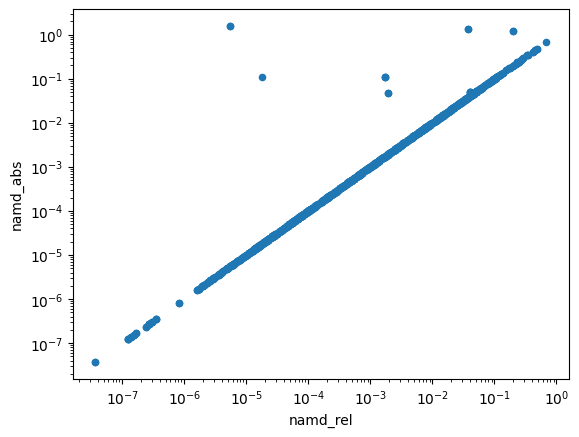

In [11]:
_ = (
    df.groupby("hostname")[["namd_rel", "namd_abs"]]
    .transform("mean")
    .plot(kind="scatter", x="namd_rel", y="namd_abs", loglog=True)
)

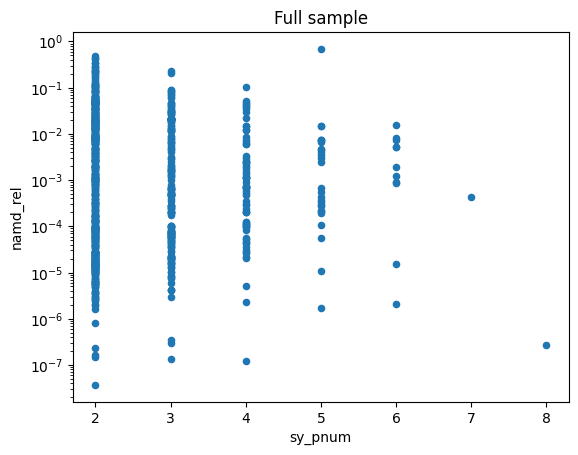

In [12]:
_ = (
    df.groupby("hostname")[["sy_pnum", "namd_rel"]]
    .mean()
    .reset_index()
    .plot(kind="scatter", x="sy_pnum", y="namd_rel", logy=True, title="Full sample")
)

Core sample


In [13]:
core_flags = ["0", "05+", "05-", "05+-"]
df_core = df.groupby("hostname").filter(lambda x: all(x["flag"].isin(core_flags)))

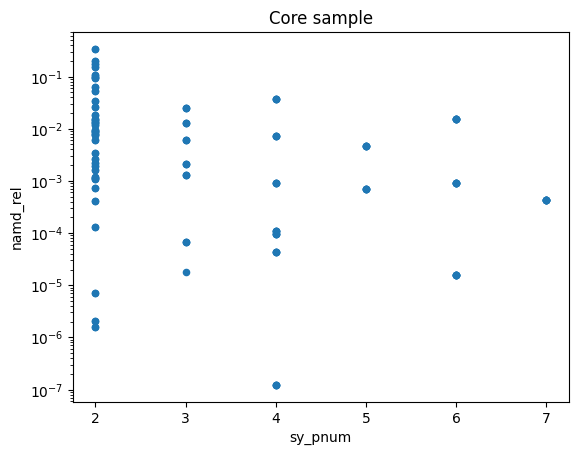

In [14]:
_ = (
    df_core.groupby("hostname")[["sy_pnum", "namd_rel"]]
    .transform("mean")
    .plot(kind="scatter", x="sy_pnum", y="namd_rel", logy=True, title="Core sample")
)

### Task 9: computing the NAMD and associated confidence intervals


In [15]:
Npt = 200000
threshold = 100

In [16]:
df_core = groupby_apply_merge(
    df_core,
    "hostname",
    solve_namd_mc,
    kind="rel",
    Npt=Npt,
    threshold=threshold,
    allow_overwrite=True,
)

df_core = groupby_apply_merge(
    df_core,
    "hostname",
    solve_namd_mc,
    kind="abs",
    Npt=Npt,
    threshold=threshold,
    allow_overwrite=True,
)

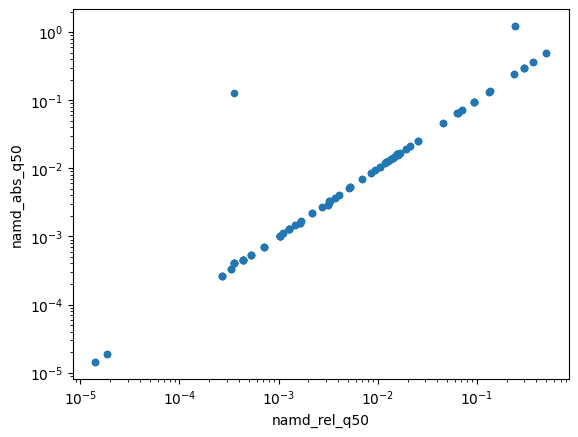

In [17]:
_ = (
    df_core.groupby("hostname")[["namd_rel_q50", "namd_abs_q50"]]
    .transform("mean")
    .plot(kind="scatter", x="namd_rel_q50", y="namd_abs_q50", loglog=True)
)

In [18]:
df_core.to_csv(os.path.join(ROOT, "data", "exo_namd.csv"), index=False)

In [19]:
df_core = pd.read_csv(os.path.join(ROOT, "data", "exo_namd.csv"))

### Some plots


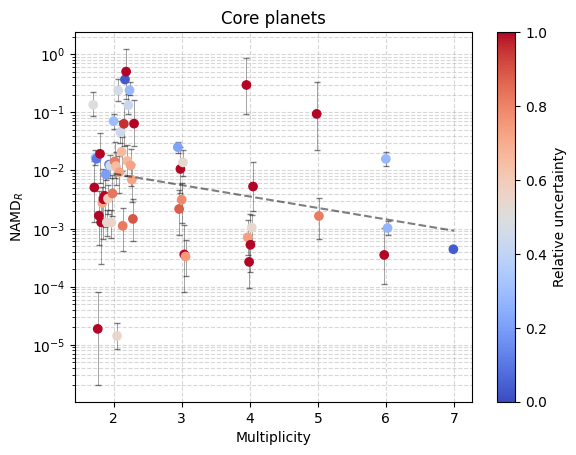

In [20]:
pop_plot(
    df=df_core.groupby("hostname").apply(
        lambda g: g.select_dtypes(exclude=["object"]).mean(),
        include_groups=False,
    ),
    kind="rel",
    title="Core planets",
    which="namd",
    yscale="log",
    xoffs=True,
)

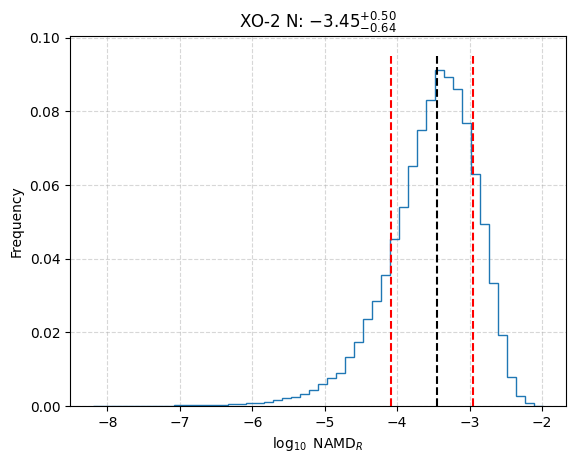

In [27]:
hostname = "XO-2 N"
host = df_core[df_core["hostname"] == hostname]

retval = solve_namd_mc(
    host=host,
    kind="rel",
    Npt=Npt,
    threshold=threshold,
    full=True,
)

simple_plot(
    df=retval,
    kind="rel",
    title=hostname,
    which="namd",
    scale="log",
)

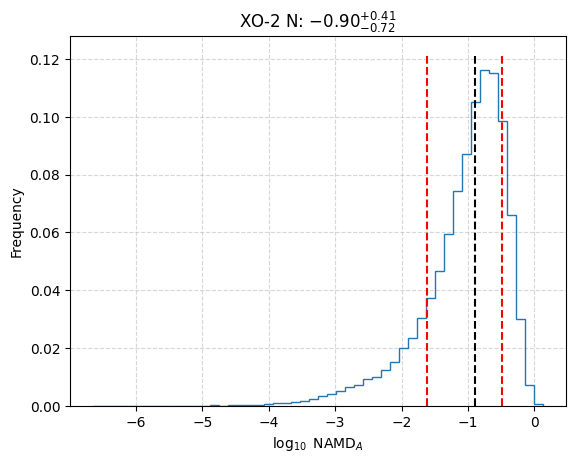

In [28]:
retval = solve_namd_mc(
    host=host,
    kind="abs",
    Npt=Npt,
    threshold=threshold,
    full=True,
)

simple_plot(
    df=retval,
    kind="abs",
    title=hostname,
    which="namd",
    scale="log",
)